In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
poi_train_x = np.matrix(poi_train_x.to_numpy())
poi_train_y = pd.read_csv('train_y.csv')
poi_train_y = poi_train_y['Life Expectancy'].tolist()
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

# num of max poisoning points, max 20% poison rate
poison_ct = 328
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  328  Train count:  1319  Test count:  165  Proportion of poisoning:  0.19914996964177292


# Inverse Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  55  ****
*****************************
Iteration  0 
Objective Value:  0.03536518813350768  Change:  0.03536518813350768
Validation MSE  0.0053093544243453215 
Test MSE  0.00707019759374181
 
Iteration  1
Objective Value: 0.04701115915272938  Difference:  0.011645971019221699
 
Iteration  2
Objective Value: 0.047457535582568676  Difference:  0.00044637642983929443
 
Iteration  3
Objective Value: 0.04789863929744501  Difference:  0.00044110371487633693
 
Iteration  4
Objective Value: 0.047713402624367796  Difference:  -0.0001852366730772173
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.04782110591250034  Difference:  -7.753338494467105e-05
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.047884123299132865  Difference:  -1.4515998312147893e-05
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.04790786513595759  Difference:  9.225838512580409e-06
 
Iteration  8
Objective Value: 0.

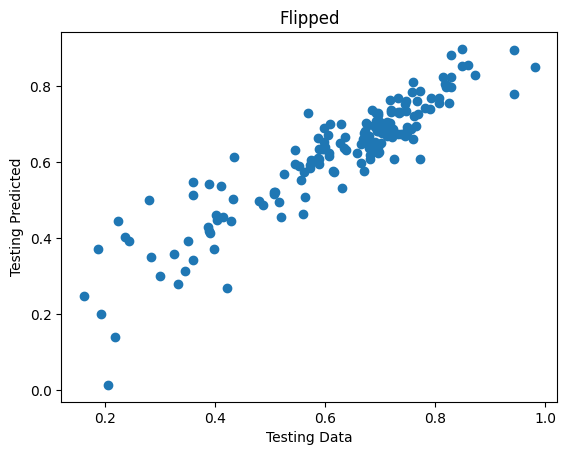

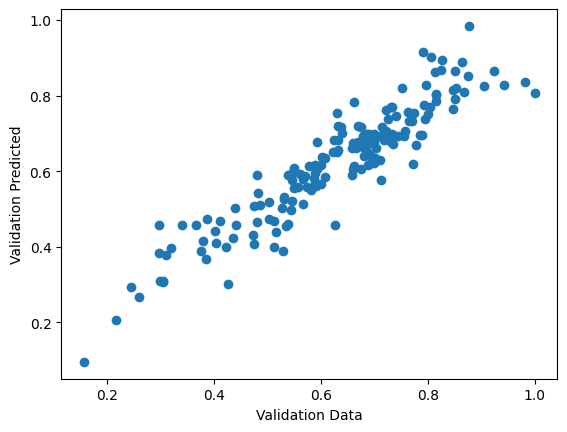

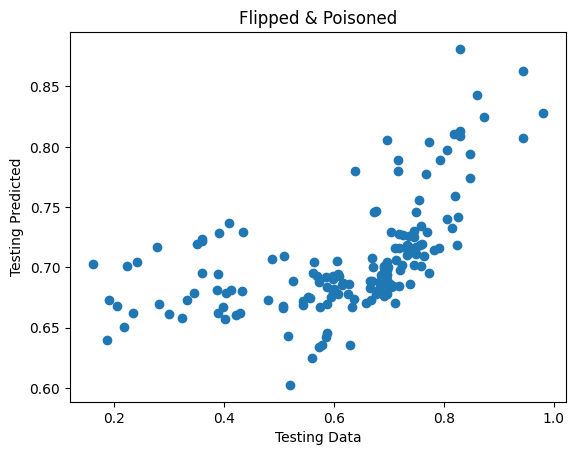

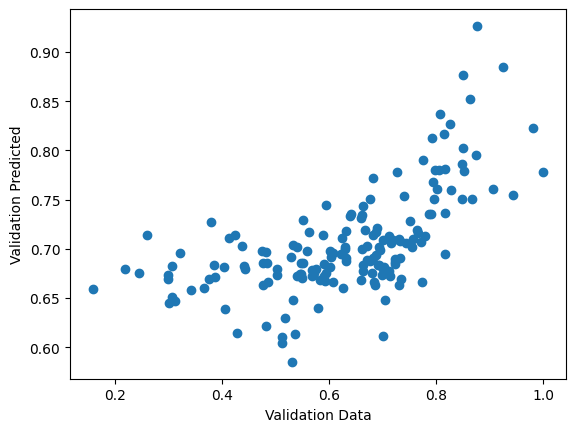


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037249733701270695 
 Test MSE: 0.004722250058956812

After Flipping & Poisoning:
 Validation MSE:  0.024512605950016458 
 Test MSE: 0.02900114169477708


In [3]:
# flip the data
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.02 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-4 # poisoning stop condition
stop1 = 10
stop2 = 30
stop3 = 10
decrease_rate = 0.75

poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# B Flip & Ridge Poisoner

classifier:  Ridge(alpha=0.1, max_iter=10000)


*****************************
**** Poison Count:  55  ****
*****************************
Iteration  0 
Objective Value:  0.03711353988321002  Change:  0.03711353988321002
Validation MSE  0.005072523472431996 
Test MSE  0.005795665613086947
 
Iteration  1
Objective Value: 0.09091885253765306  Difference:  0.053805312654443035
 
Iteration  2
Objective Value: 0.07373377256833179  Difference:  -0.017185079969321268
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.07759981688557555  Difference:  -0.01331903565207751
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.08129669005658814  Difference:  -0.009622162481064914
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.08398285211879332  Difference:  -0.006936000418859736
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.08591397652078567  Difference:  -0.005004876016867388
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.08726400218759454  Difference:  -0.003654850350058511
NO PROGR

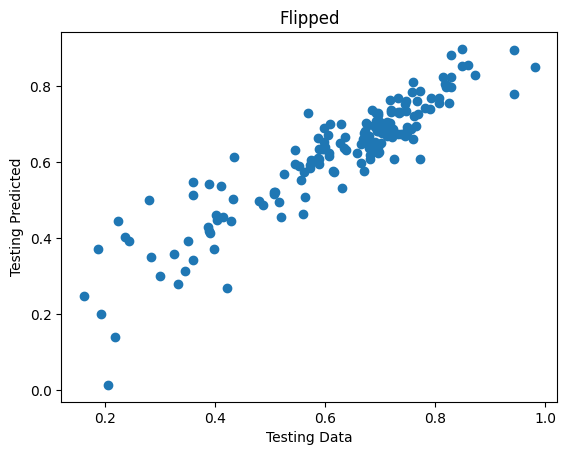

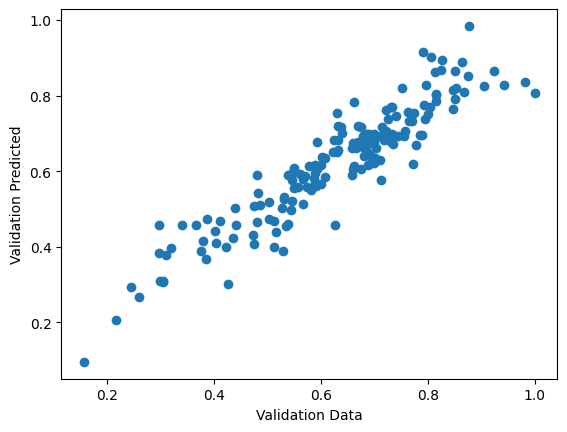

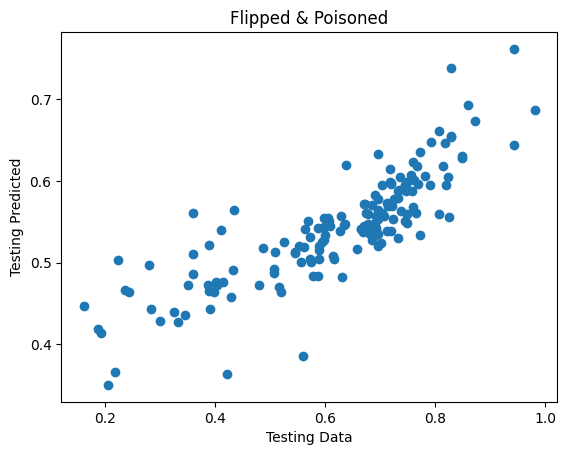

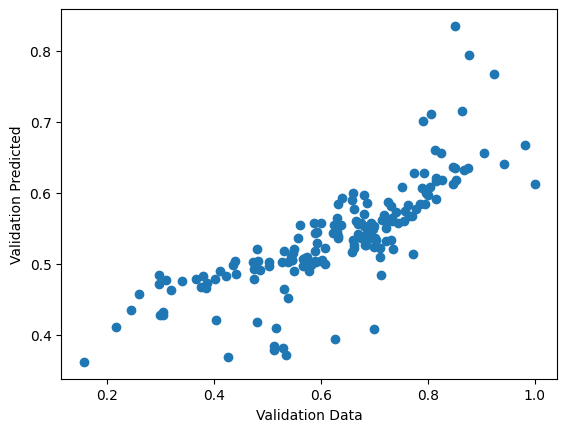


Poison Proportion:  19.91 %. Max reached, terminate

After Flipping, Unpoisoned 
 Validation MSE:  0.0037249733701270695 
 Test MSE: 0.004722250058956812

After Flipping & Poisoning:
 Validation MSE:  0.02116492568823432 
 Test MSE: 0.02045377262554655


In [4]:
# flip the data
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

poiser = gd_poisoner.ridge_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier,False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois,stop1, stop2, stop3, decrease_rate)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, lam = poiser.learn_model(x_poised,y_poised,None)
    print("Poisoned classifier: ", classifier_poised, ", \nReturned lambda: ", lam)
    classifier = poiser.init_classifier
    if i != 4:
        err_unpoised = poiser.compute_error(classifier,False,False)
        err = poiser.compute_error(classifier_poised,False,False)
        print("\nPoison Proportion: ", round(current_prop*100,2),"%")
    else:
        err_unpoised = poiser.compute_error(classifier,True,False)
        err = poiser.compute_error(classifier_poised,True,True)
        print("\nPoison Proportion: ", round(total_prop*100,2), "%. Max reached, terminate")
    print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
    print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])